# gw-thal 1:2 Bifurcation Diagrams

# Inits

In [1]:
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
# user-defined
import nmCoupling as nm
# import nmCoupling_old as nm
import response as rp

import gwt
import thal2 as t2
import gw2 as g2

from lib.util import (get_phase, freq_est, get_tongue_1d, pl_exist_1d, get_period, bif1d, follow_phase_diffs, phase_lock_r3d, follow_locking_3d, get_initial_phase_diff_c, get_period)

from lib.rhs import _redu_c, _full, _redu_full
from lib.rhs import _redu_3dc_thal as _redu_3dc
from lib.rhs import _redu_4dc_thal as _redu_4dc

from lib.plot_util import add_diagram_1d_scatter, quick_plot_combined

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sym

from scipy.optimize import root,bisect
from copy import deepcopy
import os

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

nmc = nm.nmCoupling
rsp = rp.Response

## Dicts

In [2]:
kw_sim = {'rtol':1e-7,'atol':1e-7,'method':'LSODA'}

In [3]:
pd_thal = {'gL':0.05,'gna':3,'gk':5,
           'gt':5,'eL':-70,'ena':50,
           'ek':-90,'et':0,'esyn':-90,
           'c':1,'alpha':3,'beta':2,
           'sigmat':0.8,'vt':-20,
           'ib':8.5,'del':0,'om':1,'om_fix':1}

In [4]:
pd_gw = {'v1':.84,'v2':.42,'v4':.35,'v6':.35,'v8':1,
         'k1':1,'k2':1,'k3':.7,'k4':1,'k5':.7,
         'k6':1,'k7':.35,'k8':1,'K':0.5,'kc':1,
         'n':6,'L':0,'del':0,'om':1,'om_fix':1}

In [5]:
# default period must be 2*np.pi
kw_thal = {'var_names':['v','h','r','w'],
        'pardict':pd_thal,
        'rhs':t2.rhs,
        'coupling':gwt.coupling_thal,
        'init':np.array([-.64,0.71,0.25,0,6]),
        'TN':20000,
        'trunc_order':3,
        'z_forward':False,
        'i_forward':[False,True,False,False,False,False],
        'i_bad_dx':[False,True,False,False,False,False],
        'max_iter':50,
        'rtol':1e-12,
        'atol':1e-12,
        'rel_tol':1e-9,
        'save_fig':False,
        'lc_prominence':.05,
        'factor':.5}

In [6]:
kw_gw = {'var_names':['x','y','z','v'],
        'pardict':pd_gw,
        'rhs':g2.rhs,
        'coupling':gwt.coupling_gw,
        'init':np.array([.3882,.523,1.357,.4347,24.2]),
        'TN':20000,
        'trunc_order':3,
        'z_forward':False,
        'i_forward':[False,True,False,False,False,False,False],
        'i_bad_dx':[False,True,False,False,False,False,False],
        'max_iter':50,
        'rtol':1e-12,
        'atol':1e-12,
        'rel_tol':1e-9,
        'save_fig':False,
        'lc_prominence':.05,
        'factor':.5}

## Defs

In [7]:
kw_bif = {'method':'LSODA','dense_output':True,'rtol':1e-9,'atol':1e-9}

In [8]:
etup12 = (.001,.15,200)
eps_list12r = np.linspace(*etup12)

In [9]:
x_temp = np.linspace(-np.pi,3*np.pi,500)

In [10]:
ss,dss=np.linspace(0,2,100,retstep=True)

## Initialize Response Functions

In [11]:
system1 = rsp(idx=0,model_name='gwt0',**kw_thal)
system2 = rsp(idx=1,model_name='gwt1',**kw_gw)

mkdir ./data/gwt0/
* Loading LC data...
self.T 6.283185307179586 omfix 0.9901981522495121
* Loading monodromy...
* Floquet Exponent kappa =-0.02435447459610879
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...
mkdir ./data/gwt1/
* Loading LC data...
self.T 6.283185307179586 omfix 3.8590183230656914
* Loading monodromy...
* Floquet Exponent kappa =-0.15846659975601737
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...


In [12]:
recompute_list = ['h_data_gwt0','h_data_gwt1','p_data_gwt0','p_data_gwt1']
# recompute_list = []
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',1),'_m':('om1',2),
        'NH':2048,'save_fig':False,'recompute_list':recompute_list}

# del=0.0

In [13]:
del12_p0 = 0
a12_p0 = nm.nmCoupling(**kw_nm, del1=del12_p0)

pfactor 30
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
p order=1
p order=1
p order=2
p order=2
p order=3
p order=3
* Loading H symbolic...
* Loading H symbolic...
* Computing H gwt0, order=0...
* Computing H gwt1, order=0...
* Computing H gwt0, order=1...
* Computing H gwt1, order=1...
* Computing H gwt0, order=2...
* Computing H gwt1, order=2...
* Computing H gwt0, order=3...
* Computing H gwt1, order=3...


## Get Branches Full

In [14]:
kw_follow = {'a':a12_p0,'del1':del12_p0,'recompute':False,
         'bifdir':'bif1d_gwt/','_full_rhs':_full}

In [15]:
data_list = []

In [16]:
in_dicts = [dict(init=0,eps_init=0.1,eps_final=0.005,deps=-.005),
            dict(init=0,eps_init=0.01,eps_final=0.0009,deps=-.001),
            dict(init=0,eps_init=0.1,eps_final=0.16,deps=.01)]

In [17]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_follow)
    data_list.append(dat)
fname = kw_follow['bifdir']+'hyper_gwt_12_p0.txt'

fname1 td_branch_init=0_nm=12_del=0_ei=0.1_ef=0.005_de=-0.005.txt
fname2 ts_branch_init=0_nm=12_del=0_ei=0.1_ef=0.005_de=-0.005.txt
fname1 td_branch_init=0_nm=12_del=0_ei=0.01_ef=0.0009_de=-0.001.txt
fname2 ts_branch_init=0_nm=12_del=0_ei=0.01_ef=0.0009_de=-0.001.txt
fname1 td_branch_init=0_nm=12_del=0_ei=0.1_ef=0.16_de=0.01.txt
fname2 ts_branch_init=0_nm=12_del=0_ei=0.1_ef=0.16_de=0.01.txt


In [18]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['init']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [19]:
kw_follow_r3d = {'a':a12_p0,'rhs':_redu_3dc,'recompute':False,
                 'bifdir':'bif1d_gwt/'}

In [20]:
data_list_r3d = []

In [21]:
in_dicts_r3d = [dict(init=1,eps_tup=(.01,.16,.01)),
                dict(init=1,eps_tup=(.01,.001,-.001)),
                dict(init=4,eps_tup=(.01,.16,.01)),
                dict(init=4,eps_tup=(.01,.001,-.001))]

In [22]:
for i in range(len(in_dicts_r3d)):
    in1 = in_dicts_r3d[i]
    dat = follow_locking_3d(**in1,**kw_follow_r3d)
    data_list_r3d.append(dat)
fname = kw_follow_r3d['bifdir']+'hyper_r3d_gwt_12_p0.txt'

eps_tup (0.01, 0.16, 0.01)
eps_tup (0.01, 0.001, -0.001)
eps_tup (0.01, 0.16, 0.01)
eps_tup (0.01, 0.001, -0.001)


In [23]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts_r3d),4])
for i in range(len(in_dicts_r3d)):
    hyp_inputs[i,0] = in_dicts_r3d[i]['init']
    hyp_inputs[i,1] = in_dicts_r3d[i]['eps_tup'][0]
    hyp_inputs[i,2] = in_dicts_r3d[i]['eps_tup'][1]
    hyp_inputs[i,3] = in_dicts_r3d[i]['eps_tup'][2]
np.savetxt(fname,hyp_inputs)

## Plot

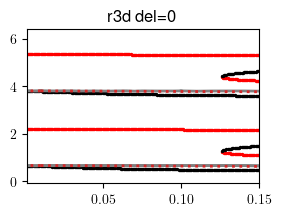

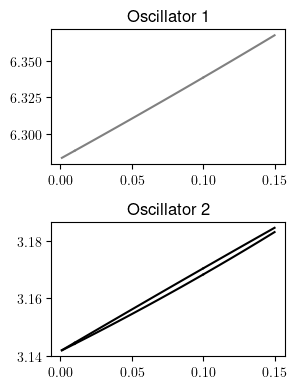

In [24]:
quick_plot_combined(a12_p0,
                    kw_f={'data_list':data_list},
                    kw_r3d={'data_list':data_list_r3d},
                    kw_r={'etup':etup12})

## Sims

In [25]:
# coupling and init
eps12_p0 = 0.1
th_init12_p0 = 2

In [26]:
# sim params
dt = .01;T_p0=200
t12_p0 = np.arange(0,T_p0,dt)
args12_p0 = {'args':(a12_p0,eps12_p0,del12_p0),
             't_eval':t12_p0,**kw_sim,'dense_output':True}

In [27]:
# initialize and run full
y0a = a12_p0.system1.lc['dat'][int((th_init12_p0/(2*np.pi)) * a12_p0.system1.TN),:]
y0b = a12_p0.system2.lc['dat'][int((0/(2*np.pi)) * a12_p0.system2.TN),:]

y0_p0 = np.array([y0a,y0b]).flatten()

solf12_p0 = solve_ivp(_full,[0,t12_p0[-1]],
                        y0_p0, **args12_p0)

In [28]:
solr12_p0 = solve_ivp(_redu_c,[0,t12_p0[-1]],
                     [th_init12_p0],**args12_p0)

In [29]:
# solr12b_p0 = solve_ivp(_redu_3dc,[0,t12_p0[-1]],
#                     [th_init12_p0,0,0],**args12_p0)

In [30]:
tp12a_p0, phase12a_p0 = get_phase(t12_p0,solf12_p0.y.T[:,:4],
                            skipn=50,system1=a12_p0.system1)
tp12b_p0, phase12b_p0 = get_phase(t12_p0,solf12_p0.y.T[:,4:],
                            skipn=50,system1=a12_p0.system2)

(-0.5, 6.783185307179586)

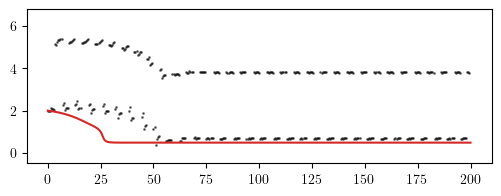

In [31]:
fig,axs = plt.subplots(figsize=(6,2))
y = np.mod(phase12a_p0 - a12_p0.om*phase12b_p0,2*np.pi)
axs.scatter(tp12a_p0,y,s=1,alpha=.5,color='black')

axs.plot(t12_p0,np.mod(solr12_p0.y.T,2*np.pi),
         color='tab:red')

axs.set_ylim(-.5,2*np.pi+.5)

(250.0, 400.0)

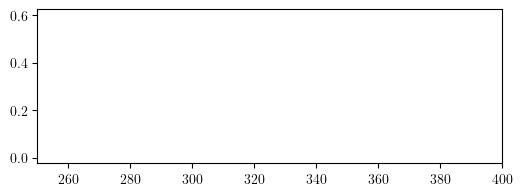

In [32]:
fig,axs = plt.subplots(figsize=(6,2))
axs.plot(solf12_p0.t,solf12_p0.y.T[:,0]+.7)
axs.plot(solf12_p0.t,solf12_p0.y.T[:,4])
axs.set_xlim(250,400)

# del=0.06

In [33]:
del12_p06 = .06
a12_p06 = nm.nmCoupling(**kw_nm, del1=del12_p06)

pfactor 30
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
p order=1
p order=1
p order=2
p order=2
p order=3
p order=3
* Loading H symbolic...
* Loading H symbolic...
* Computing H gwt0, order=0...
* Computing H gwt1, order=0...
* Computing H gwt0, order=1...
* Computing H gwt1, order=1...
* Computing H gwt0, order=2...
* Computing H gwt1, order=2...
* Computing H gwt0, order=3...
* Computing H gwt1, order=3...


## Get Branches Full

In [34]:
kw_follow = {'a':a12_p06,'del1':del12_p06,'recompute':False,
            'bifdir':'bif1d_gwt/','_full_rhs':_full}

In [35]:
data_list = []

In [36]:
in_dicts = [dict(init=0,eps_init=0.1,eps_final=0.03,deps=-.005),
            dict(init=0,eps_init=0.035,eps_final=0.0005,deps=-.001),
            dict(init=0,eps_init=0.1,eps_final=0.16,deps=.01)]

In [37]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_follow)
    data_list.append(dat)
fname = kw_follow['bifdir']+'hyper_gwt_12_p06.txt'

fname1 td_branch_init=0_nm=12_del=0.06_ei=0.1_ef=0.03_de=-0.005.txt
fname2 ts_branch_init=0_nm=12_del=0.06_ei=0.1_ef=0.03_de=-0.005.txt
fname1 td_branch_init=0_nm=12_del=0.06_ei=0.035_ef=0.0005_de=-0.001.txt
fname2 ts_branch_init=0_nm=12_del=0.06_ei=0.035_ef=0.0005_de=-0.001.txt
fname1 td_branch_init=0_nm=12_del=0.06_ei=0.1_ef=0.16_de=0.01.txt
fname2 ts_branch_init=0_nm=12_del=0.06_ei=0.1_ef=0.16_de=0.01.txt


In [38]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['init']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [39]:
kw_follow_r3d = {'a':a12_p06,'rhs':_redu_3dc,'recompute':False,
                 'bifdir':'bif1d_gwt/'}

In [40]:
data_list_r3d = []

In [41]:
in_dicts_r3d = [dict(init=6.5,eps_tup=(.05,.16,.01)),
                dict(init=6.5,eps_tup=(.05,.001,-.001)),
                dict(init=4,eps_tup=(.05,.16,.01)),
                dict(init=4,eps_tup=(.05,.001,-.001))]

In [42]:
for i in range(len(in_dicts_r3d)):
    in1 = in_dicts_r3d[i]
    dat = follow_locking_3d(**in1,**kw_follow_r3d)
    data_list_r3d.append(dat)
fname = kw_follow_r3d['bifdir']+'hyper_r3d_gwt_12_p06.txt'

eps_tup (0.05, 0.16, 0.01)
eps_tup (0.05, 0.001, -0.001)
eps_tup (0.05, 0.16, 0.01)
eps_tup (0.05, 0.001, -0.001)


In [43]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts_r3d),4])
for i in range(len(in_dicts_r3d)):
    hyp_inputs[i,0] = in_dicts_r3d[i]['init']
    hyp_inputs[i,1] = in_dicts_r3d[i]['eps_tup'][0]
    hyp_inputs[i,2] = in_dicts_r3d[i]['eps_tup'][1]
    hyp_inputs[i,3] = in_dicts_r3d[i]['eps_tup'][2]
np.savetxt(fname,hyp_inputs)

## Plot

eps_min 0.01999999999999999


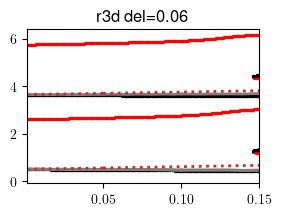

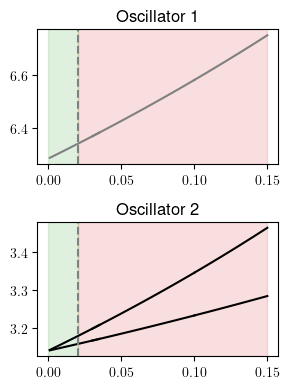

In [44]:
quick_plot_combined(a12_p06,
                    kw_f={'data_list':data_list},
                    kw_r3d={'data_list':data_list_r3d},
                    kw_r={'etup':etup12})

## Sims

In [45]:
# coupling and init
eps12_p06 = 0.1
th_init12_p06 = 2.229

In [46]:
# sim params
dt = .01;T_p06=300
t12_p06 = np.arange(0,T_p06,dt)
args12_p06 = {'args':(a12_p06,eps12_p06,del12_p06),
             't_eval':t12_p06,**kw_sim,'dense_output':True}

In [47]:
# initialize and run full
y0a = a12_p06.system1.lc['dat'][int((th_init12_p06/(2*np.pi)) * a12_p06.system1.TN),:]
y0b = a12_p06.system2.lc['dat'][int((0/(2*np.pi)) * a12_p06.system2.TN),:]

y0_p06 = np.array([y0a,y0b]).flatten()

solf12_p06 = solve_ivp(_full,[0,t12_p06[-1]],y0_p06, **args12_p06)

In [48]:
solr12_p06 = solve_ivp(_redu_c,[0,t12_p06[-1]],[th_init12_p06],**args12_p06)

In [49]:
# solr12b_p06 = solve_ivp(_redu_3dc,[0,t12_p06[-1]],
#                     [th_init12_p06,0,0],**args12_p06)

In [50]:
tp12a_p06, phase12a_p06 = get_phase(t12_p06,solf12_p06.y.T[:,:4],
                            skipn=50,system1=a12_p06.system1)
tp12b_p06, phase12b_p06 = get_phase(t12_p06,solf12_p06.y.T[:,4:],
                            skipn=50,system1=a12_p06.system2)

(-0.5, 6.783185307179586)

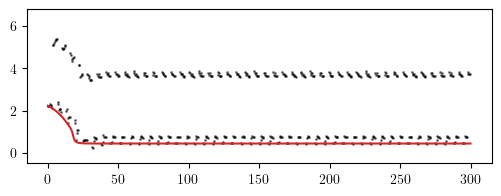

In [51]:
fig,axs = plt.subplots(figsize=(6,2))
y = np.mod(phase12a_p06 - a12_p06.om*phase12b_p06,2*np.pi)
axs.scatter(tp12a_p06,y,s=1,alpha=.5,color='black')

axs.plot(t12_p06,np.mod(solr12_p06.y.T,2*np.pi),
         color='tab:red')

axs.set_ylim(-.5,2*np.pi+.5)

# del=0.1

In [52]:
del12_p1 = .1
a12_p1 = nm.nmCoupling(**kw_nm, del1=del12_p1)

pfactor 30
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
p order=1
p order=1
p order=2
p order=2
p order=3
p order=3
* Loading H symbolic...
* Loading H symbolic...
* Computing H gwt0, order=0...
* Computing H gwt1, order=0...
* Computing H gwt0, order=1...
* Computing H gwt1, order=1...
* Computing H gwt0, order=2...
* Computing H gwt1, order=2...
* Computing H gwt0, order=3...
* Computing H gwt1, order=3...


## Get Branches Full

In [53]:
kw_follow = {'a':a12_p1,'del1':del12_p1,'recompute':False,
            'bifdir':'bif1d_gwt/','_full_rhs':_full}

In [54]:
data_list = []

In [55]:
in_dicts = [dict(init=3,eps_init=0.1,eps_final=0.01,deps=-.01),
            dict(init=3,eps_init=0.02,eps_final=0.0009,deps=-.001),
            dict(init=3,eps_init=0.1,eps_final=0.16,deps=.01)]

In [56]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_follow)
    data_list.append(dat)
fname = kw_follow['bifdir']+'hyper_gwt_12_p1.txt'

fname1 td_branch_init=3_nm=12_del=0.1_ei=0.1_ef=0.01_de=-0.01.txt
fname2 ts_branch_init=3_nm=12_del=0.1_ei=0.1_ef=0.01_de=-0.01.txt
fname1 td_branch_init=3_nm=12_del=0.1_ei=0.02_ef=0.0009_de=-0.001.txt
fname2 ts_branch_init=3_nm=12_del=0.1_ei=0.02_ef=0.0009_de=-0.001.txt
fname1 td_branch_init=3_nm=12_del=0.1_ei=0.1_ef=0.16_de=0.01.txt
fname2 ts_branch_init=3_nm=12_del=0.1_ei=0.1_ef=0.16_de=0.01.txt


In [57]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['init']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [58]:
kw_follow_r3d = {'a':a12_p1,'rhs':_redu_3dc,'recompute':False,
                 'bifdir':'bif1d_gwt/'}

In [59]:
data_list_r3d = []

In [60]:
in_dicts_r3d = [dict(init=3.5,eps_tup=(.05,.16,.01)),
                dict(init=3.5,eps_tup=(.05,.001,-.001)),
                dict(init=.5,eps_tup=(.05,.16,.01)),
                dict(init=.5,eps_tup=(.05,.001,-.001))]

In [61]:
for i in range(len(in_dicts_r3d)):
    in1 = in_dicts_r3d[i]
    dat = follow_locking_3d(**in1,**kw_follow_r3d)
    data_list_r3d.append(dat)
fname = kw_follow_r3d['bifdir']+'hyper_r3d_gwt_12_p1.txt'

eps_tup (0.05, 0.16, 0.01)
eps_tup (0.05, 0.001, -0.001)
eps_tup (0.05, 0.16, 0.01)
eps_tup (0.05, 0.001, -0.001)


In [62]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts_r3d),4])
for i in range(len(in_dicts_r3d)):
    hyp_inputs[i,0] = in_dicts_r3d[i]['init']
    hyp_inputs[i,1] = in_dicts_r3d[i]['eps_tup'][0]
    hyp_inputs[i,2] = in_dicts_r3d[i]['eps_tup'][1]
    hyp_inputs[i,3] = in_dicts_r3d[i]['eps_tup'][2]
np.savetxt(fname,hyp_inputs)

## Plot

eps_min 0.012999999999999994


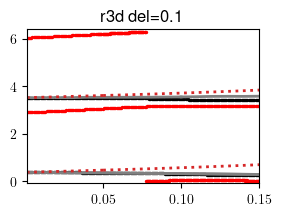

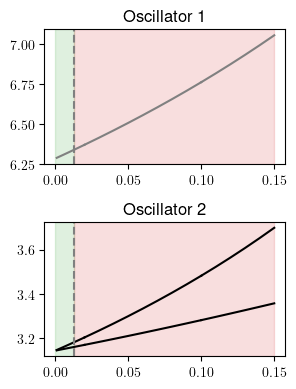

In [63]:
quick_plot_combined(a12_p1,
                    kw_f={'data_list':data_list},
                    kw_r3d={'data_list':data_list_r3d},
                    kw_r={'etup':etup12})

## Sims

In [64]:
# coupling and init
eps12_p1 = 0.15
th_init12_p1 = 2.229

In [65]:
# sim params
dt = .01;T_p1=300
t12_p1 = np.arange(0,T_p1,dt)
args12_p1 = {'args':(a12_p1,eps12_p1,del12_p1),
             't_eval':t12_p1,**kw_sim,'dense_output':True}

In [66]:
# initialize and run full
y0a = a12_p1.system1.lc['dat'][int((th_init12_p1/(2*np.pi)) * a12_p1.system1.TN),:]
y0b = a12_p1.system2.lc['dat'][int((0/(2*np.pi)) * a12_p1.system2.TN),:]

y0_p1 = np.array([y0a,y0b]).flatten()

solf12_p1 = solve_ivp(_full,[0,t12_p1[-1]],
                        y0_p1, **args12_p1)

In [67]:
solr12_p1 = solve_ivp(_redu_c,[0,t12_p1[-1]],
                     [th_init12_p1],**args12_p1)

In [68]:
# solr12b_p1 = solve_ivp(_redu_3dc,[0,t12_p1[-1]],
#                     [th_init12_p1,0,0],**args12_p1)

In [69]:
tp12a_p1, phase12a_p1 = get_phase(t12_p1,solf12_p1.y.T[:,:4],
                            skipn=50,system1=a12_p1.system1)
tp12b_p1, phase12b_p1 = get_phase(t12_p1,solf12_p1.y.T[:,4:],
                            skipn=50,system1=a12_p1.system2)

(-0.5, 6.783185307179586)

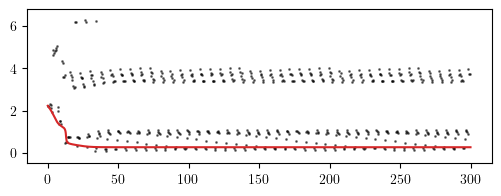

In [70]:
fig,axs = plt.subplots(figsize=(6,2))
y = np.mod(phase12a_p1 - a12_p1.om*phase12b_p1,2*np.pi)
axs.scatter(tp12a_p1,y,s=1,alpha=.5,color='black')

axs.plot(t12_p1,np.mod(solr12_p1.y.T,2*np.pi),
         color='tab:red')

axs.set_ylim(-.5,2*np.pi+.5)

# del=0.11

In [71]:
del12_p11 = .11
a12_p11 = nm.nmCoupling(**kw_nm, del1=del12_p11)

pfactor 30
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
p order=1
p order=1
p order=2
p order=2
p order=3
p order=3
* Loading H symbolic...
* Loading H symbolic...
* Computing H gwt0, order=0...
* Computing H gwt1, order=0...
* Computing H gwt0, order=1...
* Computing H gwt1, order=1...
* Computing H gwt0, order=2...
* Computing H gwt1, order=2...
* Computing H gwt0, order=3...
* Computing H gwt1, order=3...


## Get Branches Full

In [72]:
kw_follow = {'a':a12_p11,'del1':del12_p11,'recompute':False,
            'bifdir':'bif1d_gwt/','_full_rhs':_full}

In [73]:
data_list = []

In [74]:
in_dicts = [dict(init=0,eps_init=0.05,eps_final=0.11,deps=.01),
            dict(init=0,eps_init=0.05,eps_final=0.0009,deps=-.001),
            dict(init=1,eps_init=0.1,eps_final=0.16,deps=.01)]

In [75]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_follow)
    data_list.append(dat)
fname = kw_follow['bifdir']+'hyper_gwt_12_p11.txt'

fname1 td_branch_init=0_nm=12_del=0.11_ei=0.05_ef=0.11_de=0.01.txt
fname2 ts_branch_init=0_nm=12_del=0.11_ei=0.05_ef=0.11_de=0.01.txt
fname1 td_branch_init=0_nm=12_del=0.11_ei=0.05_ef=0.0009_de=-0.001.txt
fname2 ts_branch_init=0_nm=12_del=0.11_ei=0.05_ef=0.0009_de=-0.001.txt
fname1 td_branch_init=1_nm=12_del=0.11_ei=0.1_ef=0.16_de=0.01.txt
fname2 ts_branch_init=1_nm=12_del=0.11_ei=0.1_ef=0.16_de=0.01.txt


In [76]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['init']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [77]:
kw_follow_r3d = {'a':a12_p11,'rhs':_redu_3dc,'recompute':False,
                 'bifdir':'bif1d_gwt/'}

In [78]:
data_list_r3d = []

In [79]:
in_dicts_r3d = [dict(init=.5,eps_tup=(.05,.16,.01)),
                dict(init=.5,eps_tup=(.05,.001,-.001)),
                dict(init=3.5,eps_tup=(.05,.16,.01)),
                dict(init=3.5,eps_tup=(.05,.001,-.001))]

In [80]:
for i in range(len(in_dicts_r3d)):
    in1 = in_dicts_r3d[i]
    dat = follow_locking_3d(**in1,**kw_follow_r3d)
    data_list_r3d.append(dat)
fname = kw_follow_r3d['bifdir']+'hyper_r3d_gwt_12_p11.txt'

eps_tup (0.05, 0.16, 0.01)
eps_tup (0.05, 0.001, -0.001)
eps_tup (0.05, 0.16, 0.01)
eps_tup (0.05, 0.001, -0.001)


In [81]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts_r3d),4])
for i in range(len(in_dicts_r3d)):
    hyp_inputs[i,0] = in_dicts_r3d[i]['init']
    hyp_inputs[i,1] = in_dicts_r3d[i]['eps_tup'][0]
    hyp_inputs[i,2] = in_dicts_r3d[i]['eps_tup'][1]
    hyp_inputs[i,3] = in_dicts_r3d[i]['eps_tup'][2]
np.savetxt(fname,hyp_inputs)

## Plot

eps_min 0.011999999999999969


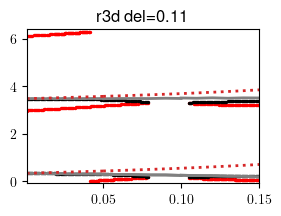

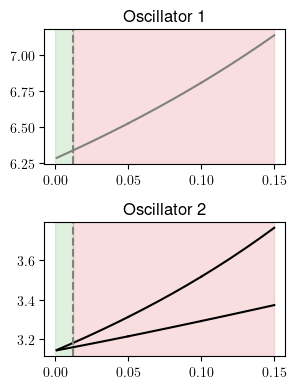

In [82]:
quick_plot_combined(a12_p11,
                    kw_f={'data_list':data_list},
                    kw_r3d={'data_list':data_list_r3d},
                    kw_r={'etup':etup12})

## Sims

In [83]:
# coupling and init
eps12_p11 = 0.095
th_init12_p11 = 2.229

In [84]:
# sim params
dt = .01;T_p11=1000
t12_p11 = np.arange(0,T_p11,dt)
args12_p11 = {'args':(a12_p11,eps12_p11,del12_p11),
             't_eval':t12_p11,**kw_sim,'dense_output':True}

In [85]:
# initialize and run full
y0a = a12_p11.system1.lc['dat'][int((th_init12_p11/(2*np.pi)) * a12_p11.system1.TN),:]
y0b = a12_p11.system2.lc['dat'][int((0/(2*np.pi)) * a12_p11.system2.TN),:]

y0_p11 = np.array([y0a,y0b]).flatten()

solf12_p11 = solve_ivp(_full,[0,t12_p11[-1]],
                        y0_p11, **args12_p11)

In [86]:
solr12_p11 = solve_ivp(_redu_c,[0,t12_p11[-1]],
                     [th_init12_p11],**args12_p11)

In [87]:
# solr12b_p11 = solve_ivp(_redu_3dc,[0,t12_p11[-1]],
#                     [th_init12_p11,0,0],**args12_p11)

In [88]:
tp12a_p11, phase12a_p11 = get_phase(t12_p11,solf12_p11.y.T[:,:4],
                            skipn=50,system1=a12_p11.system1)
tp12b_p11, phase12b_p11 = get_phase(t12_p11,solf12_p11.y.T[:,4:],
                            skipn=50,system1=a12_p11.system2)

(-0.5, 6.783185307179586)

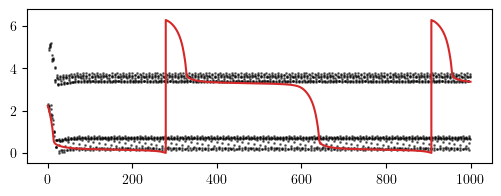

In [89]:
fig,axs = plt.subplots(figsize=(6,2))
y = np.mod(phase12a_p11 - a12_p11.om*phase12b_p11,2*np.pi)
axs.scatter(tp12a_p11,y,s=1,alpha=.5,color='black')

axs.plot(t12_p11,np.mod(solr12_p11.y.T,2*np.pi),
         color='tab:red')

axs.set_ylim(-.5,2*np.pi+.5)

# del=0.12

In [90]:
del12_p12 = .12
a12_p12 = nm.nmCoupling(**kw_nm, del1=del12_p12)

pfactor 30
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
p order=1
p order=1
p order=2
p order=2
p order=3
p order=3
* Loading H symbolic...
* Loading H symbolic...
* Computing H gwt0, order=0...
* Computing H gwt1, order=0...
* Computing H gwt0, order=1...
* Computing H gwt1, order=1...
* Computing H gwt0, order=2...
* Computing H gwt1, order=2...
* Computing H gwt0, order=3...
* Computing H gwt1, order=3...


## Get Branches Full

In [91]:
kw_follow = {'a':a12_p12,'del1':del12_p12,'recompute':False,
            'bifdir':'bif1d_gwt/','_full_rhs':_full}

In [92]:
data_list = []

In [93]:
in_dicts = [dict(init=0,eps_init=0.05,eps_final=0.09,deps=.01),
            dict(init=0,eps_init=0.05,eps_final=0.009,deps=-.005),
            dict(init=0,eps_init=0.01,eps_final=0.0009,deps=-.001)]

In [94]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_follow)
    data_list.append(dat)
fname = kw_follow['bifdir']+'hyper_gwt_12_p12.txt'

fname1 td_branch_init=0_nm=12_del=0.12_ei=0.05_ef=0.09_de=0.01.txt
fname2 ts_branch_init=0_nm=12_del=0.12_ei=0.05_ef=0.09_de=0.01.txt
fname1 td_branch_init=0_nm=12_del=0.12_ei=0.05_ef=0.009_de=-0.005.txt
fname2 ts_branch_init=0_nm=12_del=0.12_ei=0.05_ef=0.009_de=-0.005.txt
fname1 td_branch_init=0_nm=12_del=0.12_ei=0.01_ef=0.0009_de=-0.001.txt
fname2 ts_branch_init=0_nm=12_del=0.12_ei=0.01_ef=0.0009_de=-0.001.txt


In [95]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['init']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [96]:
kw_follow_r3d = {'a':a12_p12,'rhs':_redu_3dc,'recompute':False,
                 'bifdir':'bif1d_gwt/'}

In [97]:
data_list_r3d = []

In [98]:
in_dicts_r3d = [dict(init=.5,eps_tup=(.05,.16,.01)),
                dict(init=.5,eps_tup=(.05,.001,-.001)),
                dict(init=3.5,eps_tup=(.05,.16,.01)),
                dict(init=3.5,eps_tup=(.05,.001,-.001))]

In [99]:
for i in range(len(in_dicts_r3d)):
    in1 = in_dicts_r3d[i]
    dat = follow_locking_3d(**in1,**kw_follow_r3d)
    data_list_r3d.append(dat)
fname = kw_follow_r3d['bifdir']+'hyper_r3d_gwt_12_p12.txt'

eps_tup (0.05, 0.16, 0.01)
eps_tup (0.05, 0.001, -0.001)
eps_tup (0.05, 0.16, 0.01)
eps_tup (0.05, 0.001, -0.001)


In [100]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts_r3d),4])
for i in range(len(in_dicts_r3d)):
    hyp_inputs[i,0] = in_dicts_r3d[i]['init']
    hyp_inputs[i,1] = in_dicts_r3d[i]['eps_tup'][0]
    hyp_inputs[i,2] = in_dicts_r3d[i]['eps_tup'][1]
    hyp_inputs[i,3] = in_dicts_r3d[i]['eps_tup'][2]
np.savetxt(fname,hyp_inputs)

## Plot

eps_min 0.01500000000000002


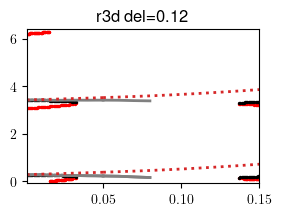

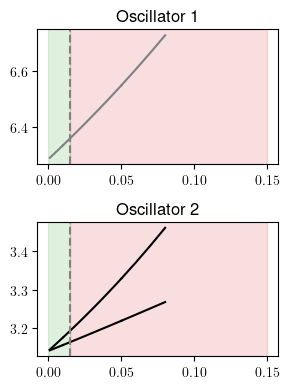

In [101]:
quick_plot_combined(a12_p12,
                    kw_f={'data_list':data_list},
                    kw_r3d={'data_list':data_list_r3d},
                    kw_r={'etup':etup12})

## Sims

In [102]:
# coupling and init
eps12_p12 = 0.095
th_init12_p12 = 2.229

In [103]:
# sim params
dt = .01;T_p12=1000
t12_p12 = np.arange(0,T_p12,dt)
args12_p12 = {'args':(a12_p12,eps12_p12,del12_p12),
             't_eval':t12_p12,**kw_sim,'dense_output':True}

In [104]:
# initialize and run full
y0a = a12_p12.system1.lc['dat'][int((th_init12_p12/(2*np.pi)) * a12_p12.system1.TN),:]
y0b = a12_p12.system2.lc['dat'][int((0/(2*np.pi)) * a12_p12.system2.TN),:]

y0_p12 = np.array([y0a,y0b]).flatten()

solf12_p12 = solve_ivp(_full,[0,t12_p12[-1]],y0_p12, **args12_p12)

In [105]:
solr12_p12 = solve_ivp(_redu_c,[0,t12_p12[-1]],[th_init12_p12],**args12_p12)

In [106]:
# solr12b_p12 = solve_ivp(_redu_3dc,[0,t12_p12[-1]],
#                     [th_init12_p12,0,0],**args12_p12)

In [107]:
tp12a_p12, phase12a_p12 = get_phase(t12_p12,solf12_p12.y.T[:,:4],
                            skipn=50,system1=a12_p12.system1)
tp12b_p12, phase12b_p12 = get_phase(t12_p12,solf12_p12.y.T[:,4:],
                            skipn=50,system1=a12_p12.system2)

(-0.5, 6.783185307179586)

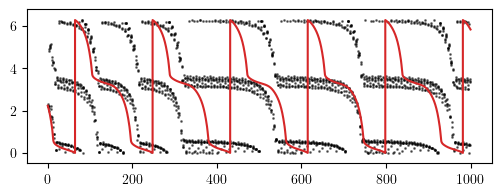

In [108]:
fig,axs = plt.subplots(figsize=(6,2))
y = np.mod(phase12a_p12 - a12_p12.om*phase12b_p12,2*np.pi)
axs.scatter(tp12a_p12,y,s=1,alpha=.5,color='black')

axs.plot(t12_p12,np.mod(solr12_p12.y.T,2*np.pi),
         color='tab:red')

axs.set_ylim(-.5,2*np.pi+.5)

# del=0.13

In [109]:
del12_p13 = .13
a12_p13 = nm.nmCoupling(**kw_nm, del1=del12_p13)

pfactor 30
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
p order=1
p order=1
p order=2
p order=2
p order=3
p order=3
* Loading H symbolic...
* Loading H symbolic...
* Computing H gwt0, order=0...
* Computing H gwt1, order=0...
* Computing H gwt0, order=1...
* Computing H gwt1, order=1...
* Computing H gwt0, order=2...
* Computing H gwt1, order=2...
* Computing H gwt0, order=3...
* Computing H gwt1, order=3...


## Get Branches Full

In [110]:
kw_follow = {'a':a12_p13,'del1':del12_p13,'recompute':False,
            'bifdir':'bif1d_gwt/','_full_rhs':_full}

In [111]:
data_list = []

In [112]:
# in_dicts = [dict(init=0,eps_init=0.05,eps_final=0.1,deps=.01),
#             dict(init=0,eps_init=0.05,eps_final=0.001,deps=-.005),
#             dict(init=1,eps_init=0.1,eps_final=0.16,deps=.01)]

In [113]:
# for i in range(len(in_dicts)):
#     in1 = in_dicts[i]
#     dat = follow_phase_diffs(**in1,**kw_follow)
#     data_list.append(dat)
# fname = kw_follow['bifdir']+'hyper_gwt_12_p13.txt'

In [114]:
# # save hyperparameters
# hyp_inputs = np.zeros([len(in_dicts),4])
# for i in range(len(in_dicts)):
#     hyp_inputs[i,0] = in_dicts[i]['init']
#     hyp_inputs[i,1] = in_dicts[i]['eps_init']
#     hyp_inputs[i,2] = in_dicts[i]['eps_final']
#     hyp_inputs[i,3] = in_dicts[i]['deps']
# np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [115]:
data_r3d_p13_list = []

In [116]:
# # find init for this branch mid
# _,init = phase_lock_r3d([0,0,0],a12_p13,.1,_redu_3dc)
# print(init)

In [117]:
# # f
# dat = follow_locking_3d(init,a12_p13,(.05,.16,.01),
#                         rhs=_redu_3dc,recompute=False,
#                        bifdir=bifdir3d)
# data_r3d_p13_list.append(dat)

In [118]:
# # b
# dat = follow_locking_3d(init,a12_p13,(.05,.005,-.002),
#                         rhs=_redu_3dc,recompute=False,
#                        bifdir=bifdir3d)
# data_r3d_p13_list.append(dat)

## Plot

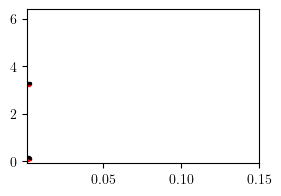

In [119]:
quick_plot_combined(a12_p13,
                    #kw_f={'data_list':data_list},
                    #kw_r3d={'data_list':data_r3d_p13_list},
                    kw_r={'etup':etup12})

## Sims

In [120]:
# coupling and init
eps12_p13 = 0.02
th_init12_p13 = 2.229

In [121]:
# sim params
dt = .01;T_p13=2000
t12_p13 = np.arange(0,T_p13,dt)
args12_p13 = {'args':(a12_p13,eps12_p13,del12_p13),
             't_eval':t12_p13,**kw_sim,'dense_output':True}

In [122]:
# initialize and run full
y0a = a12_p13.system1.lc['dat'][int((th_init12_p13/(2*np.pi)) * a12_p13.system1.TN),:]
y0b = a12_p13.system2.lc['dat'][int((0/(2*np.pi)) * a12_p13.system2.TN),:]

y0_p13 = np.array([y0a,y0b]).flatten()

solf12_p13 = solve_ivp(_full,[0,t12_p13[-1]],
                        y0_p13, **args12_p13)

In [123]:
solr12_p13 = solve_ivp(_redu_c,[0,t12_p13[-1]],
                     [th_init12_p13],**args12_p13)

In [124]:
# solr12b_p13 = solve_ivp(_redu_3dc,[0,t12_p13[-1]],
#                     [th_init12_p13,0,0],**args12_p13)

In [125]:
tp12a_p13, phase12a_p13 = get_phase(t12_p13,solf12_p13.y.T[:,:4],
                            skipn=50,system1=a12_p13.system1)
tp12b_p13, phase12b_p13 = get_phase(t12_p13,solf12_p13.y.T[:,4:],
                            skipn=50,system1=a12_p13.system2)

(-0.5, 6.783185307179586)

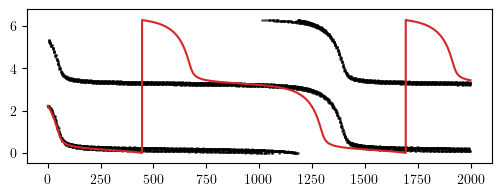

In [126]:
fig,axs = plt.subplots(figsize=(6,2))
y = np.mod(phase12a_p13 - a12_p13.om*phase12b_p13,2*np.pi)
axs.scatter(tp12a_p13,y,s=1,alpha=.5,color='black')

axs.plot(t12_p13,np.mod(solr12_p13.y.T,2*np.pi),
         color='tab:red')

axs.set_ylim(-.5,2*np.pi+.5)